kaggle link: https://www.kaggle.com/c/airbus-ship-detection/code?competitionId=9988&searchQuery=yolo

notebook link: https://www.kaggle.com/uysimty/ship-detection-using-keras-u-net

In [4]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import tensorflow as tf

# from keras.preprocessing.image import load_img
from imageio import imread

import keras.backend as K
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Activation, UpSampling2D, BatchNormalization

from skimage.transform import resize
from sklearn.model_selection import train_test_split

# Load truncated iamges https://www.kaggle.com/c/airbus-ship-detection/discussion/62574#latest-445141
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [7]:
import warnings
warnings.filterwarnings('ignore')

## Define Variables

In [8]:
IMG_WIDTH = 768
IMG_HEIGHT = 768
IMG_CHANNELS = 3
TARGET_WIDTH = 128
TARGET_HEIGHT = 128
epochs=1
batch_size=10
image_shape=(768, 768)
FAST_RUN=False # use for development only
FAST_PREDICTION=False # use for development only

## Read Data

In [9]:
df = pd.read_csv("../data/airbus-ship-detection/train_ship_segmentations_v2.csv")
sub_df = pd.read_csv("../data/airbus-ship-detection/sample_submission_v2.csv")

In [10]:
df.head()

,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


In [11]:
df.shape

(231723, 2)

In [12]:
sub_df.head()

,ImageId,EncodedPixels
0,00002bd58.jpg,1 2
1,00015efb6.jpg,1 2
2,00023d5fc.jpg,1 2
3,000367c13.jpg,1 2
4,0008ca6e9.jpg,1 2


In [13]:
sub_df.shape

(15606, 2)

In [14]:
# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
no_mask = np.zeros(image_shape[0]*image_shape[1], dtype=np.uint8)
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    rle = ' '.join(str(x) for x in runs)
    return rle

def rle_decode(mask_rle, shape=image_shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    if pd.isnull(mask_rle):
        img = no_mask
        return img.reshape(shape).T
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]

    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

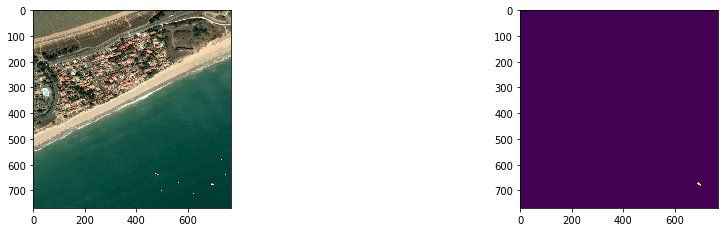

In [17]:
## Image with ship

segmentation = df[df.EncodedPixels.notnull()].sample().iloc[0]
image = imread('../data/airbus-ship-detection/train_v2/'+segmentation.ImageId)

fig=plt.figure(figsize=(16, 8))
fig.add_subplot(2, 2, 1)
plt.imshow(image)
fig.add_subplot(2, 2, 2)
plt.imshow(rle_decode(segmentation.EncodedPixels))

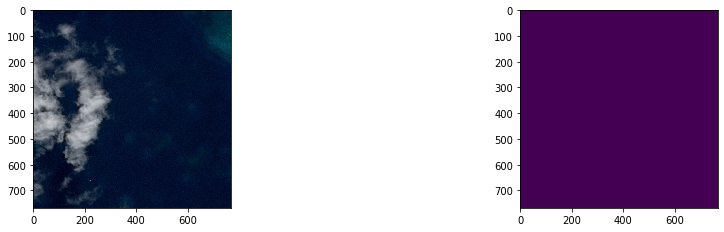

In [18]:
# Image without ship

segmentation = df[df.EncodedPixels.isnull()].sample().iloc[0]
image = imread('../data/airbus-ship-detection/train_v2/'+segmentation.ImageId)

fig=plt.figure(figsize=(16, 8))
fig.add_subplot(2, 2, 1)
plt.imshow(image)
fig.add_subplot(2, 2, 2)
plt.imshow(rle_decode(segmentation.EncodedPixels))

## Define UNET Model

In [19]:
inputs = Input((TARGET_WIDTH , TARGET_HEIGHT, IMG_CHANNELS))

# 128

down1 = Conv2D(64, (3, 3), padding='same')(inputs)
down1 = BatchNormalization()(down1)
down1 = Activation('relu')(down1)
down1 = Conv2D(64, (3, 3), padding='same')(down1)
down1 = BatchNormalization()(down1)
down1 = Activation('relu')(down1)
down1_pool = MaxPooling2D((2, 2), strides=(2, 2))(down1)
# 64

down2 = Conv2D(128, (3, 3), padding='same')(down1_pool)
down2 = BatchNormalization()(down2)
down2 = Activation('relu')(down2)
down2 = Conv2D(128, (3, 3), padding='same')(down2)
down2 = BatchNormalization()(down2)
down2 = Activation('relu')(down2)
down2_pool = MaxPooling2D((2, 2), strides=(2, 2))(down2)
# 32

down3 = Conv2D(256, (3, 3), padding='same')(down2_pool)
down3 = BatchNormalization()(down3)
down3 = Activation('relu')(down3)
down3 = Conv2D(256, (3, 3), padding='same')(down3)
down3 = BatchNormalization()(down3)
down3 = Activation('relu')(down3)
down3_pool = MaxPooling2D((2, 2), strides=(2, 2))(down3)
# 16

down4 = Conv2D(512, (3, 3), padding='same')(down3_pool)
down4 = BatchNormalization()(down4)
down4 = Activation('relu')(down4)
down4 = Conv2D(512, (3, 3), padding='same')(down4)
down4 = BatchNormalization()(down4)
down4 = Activation('relu')(down4)
down4_pool = MaxPooling2D((2, 2), strides=(2, 2))(down4)
# 8

center = Conv2D(1024, (3, 3), padding='same')(down4_pool)
center = BatchNormalization()(center)
center = Activation('relu')(center)
center = Conv2D(1024, (3, 3), padding='same')(center)
center = BatchNormalization()(center)
center = Activation('relu')(center)
# center

up4 = UpSampling2D((2, 2))(center)
up4 = concatenate([down4, up4], axis=3)
up4 = Conv2D(512, (3, 3), padding='same')(up4)
up4 = BatchNormalization()(up4)
up4 = Activation('relu')(up4)
up4 = Conv2D(512, (3, 3), padding='same')(up4)
up4 = BatchNormalization()(up4)
up4 = Activation('relu')(up4)
up4 = Conv2D(512, (3, 3), padding='same')(up4)
up4 = BatchNormalization()(up4)
up4 = Activation('relu')(up4)
# 16

up3 = UpSampling2D((2, 2))(up4)
up3 = concatenate([down3, up3], axis=3)
up3 = Conv2D(256, (3, 3), padding='same')(up3)
up3 = BatchNormalization()(up3)
up3 = Activation('relu')(up3)
up3 = Conv2D(256, (3, 3), padding='same')(up3)
up3 = BatchNormalization()(up3)
up3 = Activation('relu')(up3)
up3 = Conv2D(256, (3, 3), padding='same')(up3)
up3 = BatchNormalization()(up3)
up3 = Activation('relu')(up3)
# 32

up2 = UpSampling2D((2, 2))(up3)
up2 = concatenate([down2, up2], axis=3)
up2 = Conv2D(128, (3, 3), padding='same')(up2)
up2 = BatchNormalization()(up2)
up2 = Activation('relu')(up2)
up2 = Conv2D(128, (3, 3), padding='same')(up2)
up2 = BatchNormalization()(up2)
up2 = Activation('relu')(up2)
up2 = Conv2D(128, (3, 3), padding='same')(up2)
up2 = BatchNormalization()(up2)
up2 = Activation('relu')(up2)
# 64

up1 = UpSampling2D((2, 2))(up2)
up1 = concatenate([down1, up1], axis=3)
up1 = Conv2D(64, (3, 3), padding='same')(up1)
up1 = BatchNormalization()(up1)
up1 = Activation('relu')(up1)
up1 = Conv2D(64, (3, 3), padding='same')(up1)
up1 = BatchNormalization()(up1)
up1 = Activation('relu')(up1)
up1 = Conv2D(64, (3, 3), padding='same')(up1)
up1 = BatchNormalization()(up1)
up1 = Activation('relu')(up1)
# 128

outputs = Conv2D(1, (1, 1), activation='sigmoid')(up1)

model = Model(inputs=inputs, outputs=outputs)

In [24]:
optimizer = tf.compat.v1.train.RMSPropOptimizer(0.0001)


In [25]:
model.compile(
    optimizer=optimizer, 
    loss="binary_crossentropy", 
    metrics=["accuracy"]
)

In [26]:
# use for development to run it faster
if FAST_RUN:
    df = df.sample(n=10000).reset_index().drop(columns=["index"]) # after reset index dataframe will have one more column call index
    
if FAST_PREDICTION:
    sub_df = sub_df.sample(n=100).reset_index().drop(columns=["index"]) # after reset index dataframe will have one more column call index

## Split train and validate data

In [27]:
train_df, validate_df = train_test_split(df)


## Generator

In [28]:
def get_image(image_name):
    img = imread('../data/airbus-ship-detection/train_v2/'+image_name)[:,:,:IMG_CHANNELS]
    img = resize(img, (TARGET_WIDTH, TARGET_HEIGHT), mode='constant', preserve_range=True)
    return img
    
def get_mask(code):
    img = rle_decode(code)
    img = resize(img, (TARGET_WIDTH, TARGET_HEIGHT, 1), mode='constant', preserve_range=True)
    return img

In [29]:
def create_image_generator(precess_batch_size, data_df):
    while True:
        for k, group_df in data_df.groupby(np.arange(data_df.shape[0])//precess_batch_size):
            imgs = []
            labels = []
            for index, row in group_df.iterrows():
                # images
                original_img = get_image(row.ImageId) / 255.0
                # masks
                mask = get_mask(row.EncodedPixels) / 255.0
                
                imgs.append(original_img)
                labels.append(mask)
                
            imgs = np.array(imgs)
            labels = np.array(labels)
            yield imgs, labels

In [30]:
train_generator = create_image_generator(batch_size, train_df)
validate_generator = create_image_generator(batch_size, validate_df)

## Fit Model

In [31]:
train_steps=np.ceil(float(train_df.shape[0]) / float(batch_size)).astype(int)
validate_steps=np.ceil(float(validate_df.shape[0]) / float(batch_size)).astype(int)

history = model.fit_generator(
    train_generator, 
    steps_per_epoch=train_steps,
    validation_data=validate_generator,
    validation_steps=validate_steps,
    epochs=epochs
)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 17380 steps, validate for 5794 steps
  591/17380 [>.............................] - ETA: 109:02:49 - loss: 0.1849 - accuracy: 0.9433

KeyboardInterrupt: 

## Predictions